# **Detection of AI-Generated Sneakers Using PyTorch and GANs**

This project specifically focuses on images of sneakers from popular brands such as Nike, Adidas, and Converse. The dataset used in this study consists of a mix of real images obtained from Google Images and AI-generated images produced by MidJourney, presenting a unique challenge in the field of computer vision and machine learning. Additionally, this project incorporates the use of Generative Adversarial Networks (GANs) to generate synthetic sneaker images, enriching the dataset and testing the robustness of detection models.

This dataset has been carefully compiled from three distinct datasets available on Kaggle, providing a solid foundation for training convolutional neural networks (CNNs). The objective is to accurately distinguish AI-generated sneaker images from real ones by leveraging subtle differences that may exist between these two types of images. The dataset is structured into two main categories:

Real Images: These authentic images, sourced from Google Images, showcase a variety of sneaker designs from Nike, Adidas, and Converse. This part of the dataset represents the "ground truth" in our classification tasks.

AI-Generated Images: This category includes synthetically created images using the MidJourney AI platform, as well as images generated by a Generative Adversarial Network (GAN). These images mimic the styles and details of real sneakers but may contain subtle imperfections or stylistic elements characteristic of AI-generated content.

Both categories of images are standardized to a resolution of 240x240 pixels. AI-generated images have been compressed and resized to match the dimensions of real images, ensuring consistency in input data for model training. For those interested in analyzing the images in full resolution, references to the original datasets are provided below.

---

# **Use of GANs in This Project**
Generative Adversarial Networks (GANs) play a key role in this project. A GAN consists of two neural networks: a generator and a discriminator, which compete in an adversarial process. The generator creates synthetic images from random noise, while the discriminator attempts to distinguish real images from generated ones. This process enables the generator to gradually improve the quality of the images it produces.

In this project, the GAN is used to:

Generate synthetic sneaker images: These images are added to the dataset to enhance the diversity of training examples.
Test the robustness of the detection model: By using images generated by the GAN, we can evaluate the model’s ability to distinguish real images from synthetic ones, even when they are highly realistic.

---



# **Chargement des données et préparation**

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
from google.colab import drive
drive.mount('/content/drive')
# Installer kagglehub si ce n'est pas déjà fait
!pip install kagglehub --quiet

# Importer les bibliothèques nécessaires
import kagglehub
import torch
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, random_split

# Télécharger directement le dataset depuis Kaggle
dataset_path = kagglehub.dataset_download('sunnykakar/shoes-dataset-real-and-ai-generated-images')

# Définir les transformations des images
transform = transforms.Compose([
    transforms.ToTensor(),  # Convertir les images en tenseurs PyTorch
])

# Charger le dataset dans PyTorch
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Vérifier la taille totale du dataset
total_size = len(dataset)
train_size = int(0.6 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size  # Ajustement pour éviter les erreurs

# Diviser en train/val/test
train_dataset, remaining_dataset = random_split(dataset, [train_size, total_size - train_size])
val_dataset, test_dataset = random_split(remaining_dataset, [val_size, test_size])

# Créer les DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Vérifier que tout est bien chargé
print(f" Dataset chargé avec succès depuis KaggleHub !")
print(f"Train : {len(train_dataset)} images, Validation : {len(val_dataset)} images, Test : {len(test_dataset)} images")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Dataset chargé avec succès depuis KaggleHub !
Train : 1308 images, Validation : 436 images, Test : 437 images


## **Vérification des DataLoaders**

In [ ]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Testing batches: {len(test_loader)}")
for X, y in train_loader:
    print("Training batch - X shape:", X.shape, "Y shape:", y.shape)
    break  # Just checking one batch to see if it loads correctly

for X, y in val_loader:
    print("Validation batch - X shape:", X.shape, "Y shape:", y.shape)
    break  # Checking one validation batch

for X, y in test_loader:
    print("Testing batch - X shape:", X.shape, "Y shape:", y.shape)
    break  # Similarly, checking one test batch

Training batches: 41
Validation batches: 14
Testing batches: 14
Training batch - X shape: torch.Size([32, 3, 240, 240]) Y shape: torch.Size([32])
Validation batch - X shape: torch.Size([32, 3, 240, 240]) Y shape: torch.Size([32])
Testing batch - X shape: torch.Size([32, 3, 240, 240]) Y shape: torch.Size([32])


## **Dictionnaire des classes**

In [ ]:
class_dict = {
    0: "AI",
    1: "Real"
}

batch = next(iter(train_loader))
images, labels = batch
images = images.numpy()

# **Visualisation des échantillons**

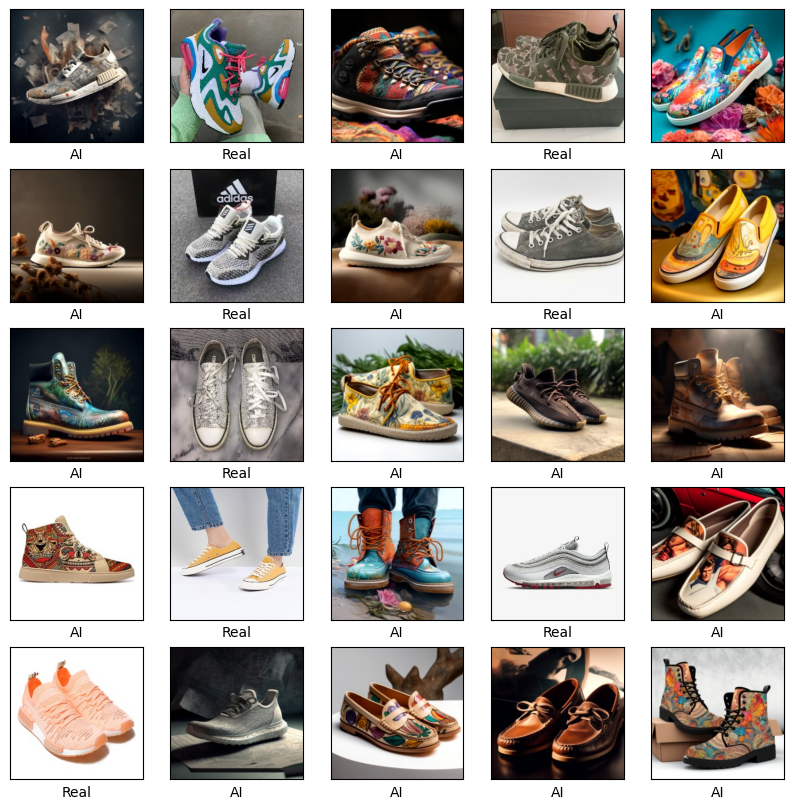

In [ ]:
def view_samples():
    plt.figure(figsize=(10, 10))
    for index in range(25):
        plt.subplot(5, 5, index + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img = np.transpose(images[index], (1, 2, 0))
        plt.imshow(img, cmap=plt.cm.binary)
        plt.xlabel(class_dict[labels[index].item()])
    plt.show()


view_samples()

## **Model Training**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels = len(class_dict)
print(torch.cuda.is_available())

True


In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3),  # 238 x 238 x 32
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3),  # 236 x 236 x 32
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2), # 118 x 118 x 32
            nn.Conv2d(32, 64, kernel_size=3),  # 116 x 116 x 64
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3),  # 114 x 114 x 64
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2), # 57 x 57 x 64
            nn.Conv2d(64, 128, kernel_size=3),  # 55 x 55 x 128
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3),  # 53 x 53 x 128
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2), # 26 x 26 x 128
            nn.Flatten(),
            nn.Linear(in_features=26*26*128, out_features=512),
            nn.ReLU(),
            nn.Linear(512, 2),
        )

    def forward(self, x):
        x = self.layers(x)
        return x


model = CNN()
model.to(device)

CNN(
  (layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (15): ReLU()
    (16): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, t

# **Fonctions d'entraînement et d'évaluation**

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    train_loss, correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.float().to(device), y.long().to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    average_train_loss = train_loss / num_batches
    train_accuracy = correct / size
    print(f"Training Error: \n Accuracy: {(100*train_accuracy):>0.1f}%, Avg loss: {average_train_loss:>8f} \n")
    return average_train_loss, train_accuracy

def val_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    val_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.float().to(device), y.long().to(device)
            pred = model(X)
            val_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    average_val_loss = val_loss / num_batches
    val_accuracy = correct / size
    print(f"Validation Error: \n Accuracy: {(100*val_accuracy):>0.1f}%, Validation loss: {average_val_loss:>8f} \n")
    return average_val_loss, val_accuracy

def evaluate_model(loader, model, loss_fn):
    model.eval()
    y_true = []
    y_pred = []
    total_loss = 0
    correct_examples = []
    incorrect_examples = []
    with torch.no_grad():
        for X, y in loader:
            X, y = X.float().to(device), y.long().to(device)
            outputs = model(X)
            loss = loss_fn(outputs, y)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            y_true.extend(y.tolist())
            y_pred.extend(predicted.tolist())
            matches = predicted == y
            for i in range(len(matches)):
                example = (X[i].cpu(), y[i].item(), predicted[i].item())
                if matches[i]:
                    correct_examples.append(example)
                else:
                    incorrect_examples.append(example)

    average_loss = total_loss / len(loader)
    accuracy = (np.array(y_true) == np.array(y_pred)).mean()
    return y_true, y_pred, average_loss, accuracy, correct_examples, incorrect_examples

# **Intégration du GAN**

In [ ]:
from torch.optim.lr_scheduler import StepLR  # Ajoutez cette ligne

# Définir le Generator et le Discriminator
class Generator(nn.Module):
    def __init__(self, latent_dim, img_channels, feature_maps):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, feature_maps * 8, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(feature_maps * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(feature_maps * 8, feature_maps * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(feature_maps * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(feature_maps * 4, feature_maps * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(feature_maps * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(feature_maps * 2, img_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.net(x)

class Discriminator(nn.Module):
    def __init__(self, img_channels, feature_maps):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(img_channels, feature_maps * 2, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),  # Ajout de Dropout
            nn.Conv2d(feature_maps * 2, feature_maps * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(feature_maps * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),  # Ajout de Dropout
            nn.Conv2d(feature_maps * 4, feature_maps * 8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(feature_maps * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),  # Ajout de Dropout
            nn.Conv2d(feature_maps * 8, 1, kernel_size=4, stride=1, padding=0),
            nn.AdaptiveAvgPool2d(1),  # Ajout d'une couche de pooling pour réduire la sortie à [batch_size, 1, 1, 1]
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.net(x)
        return x.view(x.size(0), -1)  # Redimensionner la sortie à [batch_size, 1]

# Hyperparamètres pour le GAN
latent_dim = 100
img_channels = 3
feature_maps = 64

# Initialisation du Generator et du Discriminator
generator = Generator(latent_dim, img_channels, feature_maps).to(device)
discriminator = Discriminator(img_channels, feature_maps).to(device)

# Optimiseurs pour le GAN
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.002, betas=(0.5, 0.999))

# Fonction de perte pour le GAN
criterion = nn.BCELoss()

# Boucle d'entraînement pour le GAN
def train_gan(epoch, dataloader):
    for i, (real_images, _) in enumerate(dataloader):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Labels réels et faux
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Entraînement du Discriminator
        optimizer_D.zero_grad()

        # Forward pass pour les images réelles
        real_outputs = discriminator(real_images)
        d_loss_real = criterion(real_outputs, real_labels)

        # Forward pass pour les images générées
        z = torch.randn(batch_size, latent_dim, 1, 1).to(device)  # Bruit aléatoire
        fake_images = generator(z)
        fake_outputs = discriminator(fake_images.detach())
        d_loss_fake = criterion(fake_outputs, fake_labels)

        # Perte totale du Discriminator
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_D.step()

        # Entraînement du Generator
        optimizer_G.zero_grad()

        # Forward pass pour les images générées
        fake_outputs = discriminator(fake_images)
        g_loss = criterion(fake_outputs, real_labels)  # Le Generator essaie de tromper le Discriminator

        # Mise à jour du Generator
        g_loss.backward()
        optimizer_G.step()

        # Affichage des résultats
        if i % 50 == 0:
            print(f"Epoch [{epoch}/{epochs}], Step [{i}/{len(dataloader)}], "
                  f"d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}")

# Définir le learning rate et les fonctions de perte et d'optimisation
learning_rate = 0.001  # Réduire le learning rate
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)  # Plus d'erreur ici

# Listes pour stocker les métriques
train_losses = []
test_losses = []
val_losses = []
train_accs = []
test_accs = []
val_accs = []

# Nombre d'époques
epochs = 30  # Augmenté pour permettre plus de convergence
max_acc = 0
patience = 3
best_val_loss = float('inf')
epochs_without_improvement = 0

# Boucle d'entraînement principale
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")

    # Exécuter l'entraînement et l'évaluation du modèle principal
    train_loss, train_acc = train_loop(train_loader, model, loss_fn, optimizer)
    val_loss, val_acc = val_loop(val_loader, model, loss_fn)

    # Stocker les valeurs de perte et d'accuracy
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print("Early stopping")
            break

    # Sauvegarde du meilleur modèle
    if val_acc > max_acc:
        print(f"[SAVING] Validation Accuracy Improved ({(100*max_acc):>0.1f}% -> {(100*val_acc):>0.1f}%)")
        max_acc = val_acc
        torch.save(model.state_dict(), "/content/saved_model.pth")
        torch.save(generator.state_dict(), "/content/generator.pth")
        torch.save(discriminator.state_dict(), "/content/discriminator.pth")

    # Ajustement du taux d'apprentissage
    scheduler.step()

    # Entraînement du GAN
    train_gan(t, train_loader)  # Utilisation du train_loader pour le GAN

print("Done!")

Epoch 1
-------------------------------
loss: 0.749038  [   32/ 1308]
loss: 5.491778  [  352/ 1308]
loss: 0.123368  [  672/ 1308]
loss: 0.672976  [  992/ 1308]
loss: 0.319782  [ 1308/ 1308]
Training Error: 
 Accuracy: 84.2%, Avg loss: 2.854505 

Validation Error: 
 Accuracy: 47.0%, Validation loss: 5.699362 

[SAVING] Validation Accuracy Improved (0.0% -> 47.0%)
Epoch [0/30], Step [0/41], d_loss: 1.4228, g_loss: 13.7401
Epoch 2
-------------------------------
loss: 0.360251  [   32/ 1308]
loss: 0.269632  [  352/ 1308]
loss: 0.036016  [  672/ 1308]
loss: 0.240499  [  992/ 1308]
loss: 0.107074  [ 1308/ 1308]
Training Error: 
 Accuracy: 93.7%, Avg loss: 0.402538 

Validation Error: 
 Accuracy: 89.9%, Validation loss: 0.476860 

[SAVING] Validation Accuracy Improved (47.0% -> 89.9%)
Epoch [1/30], Step [0/41], d_loss: 0.0029, g_loss: 8.5320
Epoch 3
-------------------------------
loss: 0.034689  [   32/ 1308]
loss: 0.023810  [  352/ 1308]
loss: 0.330243  [  672/ 1308]
loss: 0.142141  [  992

# **Visualisation des pertes et précisions**

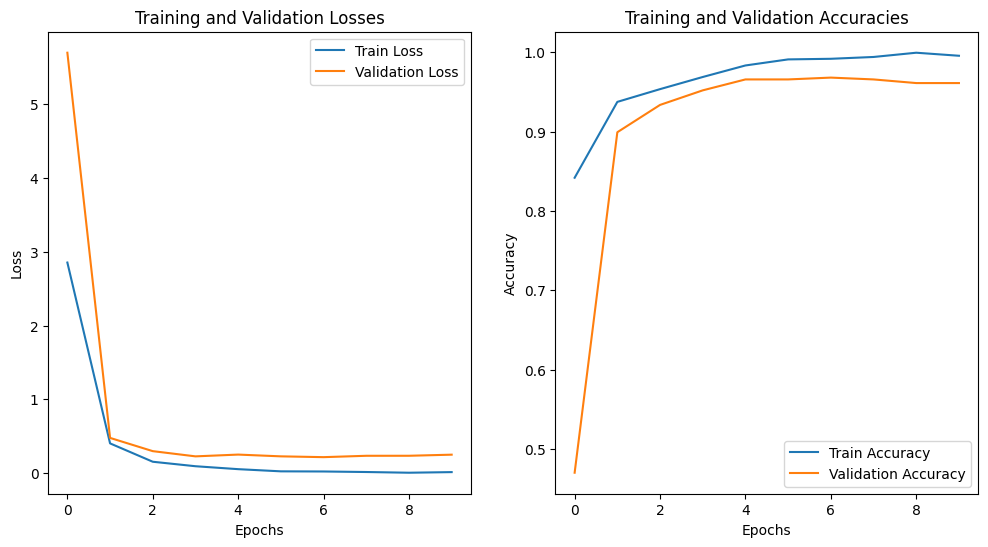

In [ ]:
plt.figure(figsize=(12, 6))

# Plotting losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Training and Validation Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plotting accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Validation Accuracy")
plt.title("Training and Validation Accuracies")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

# **Chargement du modèle sauvegardé**

In [ ]:
model.load_state_dict(torch.load("/content/saved_model.pth"))
model.to(device)

<ipython-input-118-06c8a01711f7>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/saved_model.pth"))


CNN(
  (layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (15): ReLU()
    (16): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, t

# **Évaluation du modèle**

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()

y_true, y_pred, test_loss, test_accuracy, correct_examples, incorrect_examples = evaluate_model(test_loader, model, loss_fn)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.0926
Test Accuracy: 0.9634


In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       266
           1       0.95      0.95      0.95       171

    accuracy                           0.96       437
   macro avg       0.96      0.96      0.96       437
weighted avg       0.96      0.96      0.96       437



# **Matrice de confusion**

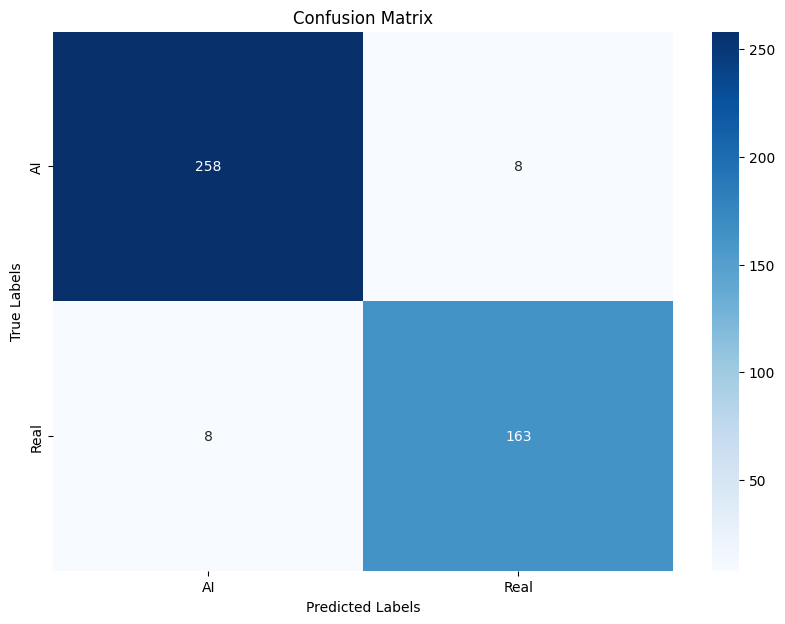

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(class_dict.values()), yticklabels=list(class_dict.values()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# **Affichage des exemples corrects**

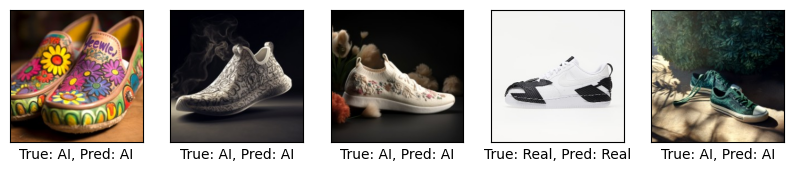

In [ ]:
def display_examples(examples):
    plt.figure(figsize=(10, 10))
    for index, (image, true_label, pred_label) in enumerate(examples[:5]):
        img = image.cpu().numpy().transpose((1, 2, 0))
        plt.subplot(5, 5, index + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(img, cmap=plt.cm.binary)
        plt.xlabel(f"True: {class_dict[true_label]}, Pred: {class_dict[pred_label]}")
    plt.show()

display_examples(correct_examples)

# **Affichage des exemples incorrects**

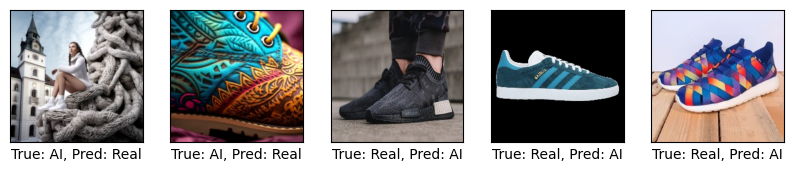

In [ ]:
display_examples(incorrect_examples)

# **Affichage des images générées par le Generator**

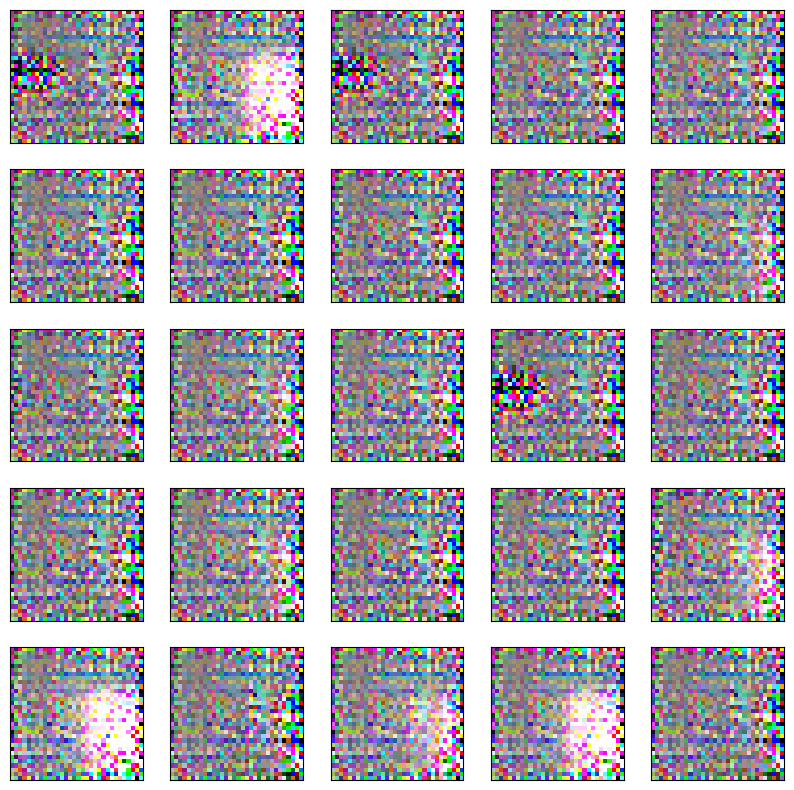

In [ ]:
def display_generated_images(generator, latent_dim, n_images=25):
    generator.eval()
    with torch.no_grad():
        z = torch.randn(n_images, latent_dim, 1, 1).to(device)
        generated_images = generator(z).cpu()

    # Normaliser les images dans la plage [0, 1]
    generated_images = (generated_images + 1) / 2  # Transforme [-1, 1] en [0, 1]

    plt.figure(figsize=(10, 10))
    for i in range(n_images):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img = generated_images[i].numpy().transpose((1, 2, 0))  # Convertir en format HWC
        plt.imshow(img, cmap=plt.cm.binary)
    plt.show()

# Afficher les images générées
display_generated_images(generator, latent_dim)